This notebook use CO2/CH4 separation as an example.\
Some important figures in the manuscript are reproduced here. Data for the figures are the output of the functions.\
For better visualization, some figure parameters can be adjusted manually in the functions.\
Available mols: CO2, CH4, H2, He, O2, N2


In [1]:
#check for unnecessary packages before publish
# all predictions are under 1 bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from matplotlib import cm
from scipy.optimize import fsolve
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import xgboost

### Section 1
All possible MOFs with 1 polymer under 1bar

In [2]:
#functions
def maxwell_model(P_MOF,P_polymer,volume_fraction=0.15):
    P_MMM = P_polymer*((P_MOF+2*P_polymer-2*volume_fraction*(P_polymer-P_MOF))/(P_MOF+2*P_polymer+volume_fraction*(P_polymer-P_MOF)))
    return P_MMM

def get_alpha_from_P(k,n,P):
    '''
    For making figures with Robeson upper bounds
    '''
    return pow(P/k, 1/n)

#reverse maxwell to get the line
def numerical_reverse_maxwell(Pd, Pc, PMMM, vf):
    term = Pc * (Pd + 2 * Pc - 2 * vf * (Pc - Pd)) / (Pd + 2 * Pc + vf * (Pc - Pd))
    return term - PMMM

# Define the reverse_maxwell_model function using fsolve
def reverse_maxwell_model(P_MMM, P_polymer, volume_fraction):
    initial_guess = 1000  # Provide a reasonable initial guess for Pd
    Pd_solution = fsolve(numerical_reverse_maxwell, initial_guess, args=(P_polymer, P_MMM, volume_fraction))
    return Pd_solution[0]

def get_rankings(lst):
    return lst[3] if len(lst) > 1 else None

def get_cat(lst):
    return lst[-1] if len(lst) > 1 else None
    

    

#################Robeson upper bound for CO2/CH4###################
k_2008=5.369*1e6
n_2008=-2.636
k_2019=22.584*1e6
n_2019=-2.401

#make a function to get predictions
def get_MMM_P(mol_1,mol_2,mof_df,P_polymer_1,P_polymer_2,polymer_alpha,upper_bound_k, upper_bound_n,plot_figure=True,save_figure=False,save_data=False,polymer_name='polymer',pressure=1e5,volume_fraction_maxwell=0.15):
    '''
    mol_1: string of mol 1
    mol_2: string of mol 2
    P_polymer_1: polymer permeability of mol_1, Barrer
    P_polymer_2: polymer permeability of mol_2, Barrer
    polymer_alpha: polymer selectivity
    upper_bound_k & upper_bound_n: upper bound parameters
    pressure: pascal
    volume_fraction_maxwell: MOF loading

    Return:
    MOF and MMM permeabilities and selectivities

    Might need to hange figure settings for better visualization
    '''
    test_cleaned_df=mof_df[(mof_df[mol_1].notna()) & (mof_df[mol_2].notna())]
    test_mof_1=np.concatenate((np.linspace(1e1, 1e2, 100),np.linspace(1e2, 1e3, 100), np.linspace(1e3, 1e4, 100), np.linspace(1e4, 1e5, 100),np.linspace(1e5, 1e6, 100),np.linspace(1e6, 1e7, 100), np.linspace(1e7, 1e8, 100)))
    test_mof_S=np.concatenate((np.linspace(1e-3, 1e-2, 100),np.linspace(1e-2, 1e-1, 100),np.linspace(1e-1, 1e0, 100), np.linspace(1e0, 1e1, 100), np.linspace(1e1, 1e2, 100),np.linspace(1e2, 1e3, 100),np.linspace(1e3, 1e4, 100)))
    test_mof_2=test_mof_1/test_mof_S
    #data processing
    # Create a meshgrid for X and Y
    X, Y = np.meshgrid(np.log10(test_mof_1), np.log10(test_mof_S))

    # Create a Z array of ones with the same shape as X and Y    
    Z_maxwell = maxwell_model(10**X,P_polymer_1,volume_fraction_maxwell)/ maxwell_model(10**(X-Y),P_polymer_2,volume_fraction_maxwell)
    Z_mof = maxwell_model(test_cleaned_df[mol_1],P_polymer_1,volume_fraction_maxwell) / maxwell_model(test_cleaned_df[mol_2],P_polymer_2,volume_fraction_maxwell)
    
    # get PMMM_1
    test_maxwell_1_MMM = maxwell_model(test_mof_1,P_polymer_1,volume_fraction_maxwell)
    
    #get corresponding alphaMMM from robeson upperbound relationship
    test_MMM_alpha=get_alpha_from_P(upper_bound_k,upper_bound_n,test_maxwell_1_MMM)
    
    #get PMMM_2
    test_MMM_2=test_maxwell_1_MMM/test_MMM_alpha
    
    #get PMOF_2 and alpha_MOF
    solved_mof_2=[]
    for i in test_MMM_2:
        solved_mof_2.append(reverse_maxwell_model(i, P_polymer_2, volume_fraction_maxwell))
    
    if plot_figure==True:
        # Create a grid with specified ratios for each subplot
        fig = plt.figure(figsize=(16, 6))  # overall figure size
        
        # Define the grid layout (1 row, 2 columns)
        grid = fig.add_gridspec(nrows=7, ncols=2, width_ratios=[1.5, 1])
        
        # First subplot: 3D plot
        ax1 = fig.add_subplot(grid[:, 0], projection='3d')
        ax1.computed_zorder = False
        
        vmin = Z_mof.min()
        vmax = Z_mof.max()
        
        # Plot the 3D surface
        surf = ax1.plot_surface(X, \
                        Y, \
                        Z_maxwell\
                        , cmap='coolwarm', vmin=vmin, vmax=vmax,
                               linewidth=0, antialiased=False, alpha =0.5, zorder=1)
        
        ax1.scatter(np.log10(test_cleaned_df[mol_1].values.astype('float64')), \
                        np.log10(test_cleaned_df[mol_1].values.astype('float64'))-np.log10(test_cleaned_df[mol_2].values.astype('float64')), \
                        Z_mof, marker = '.', zorder=4, alpha=0.3,color='black')
        
        Z = np.ones_like(X)*polymer_alpha
        
        # Step 3: Plot the contour
        cs_3 = ax1.plot3D(np.log10(test_mof_1[(test_mof_1 / solved_mof_2)>0.01]), \
                          np.log10((test_mof_1/solved_mof_2)[(test_mof_1 / solved_mof_2)>0.01])\
                          , test_MMM_alpha[(test_mof_1 / solved_mof_2)>0.01]\
                          , color='green', zorder=5)
        
        # Set axis labels
        ax1.set_xlabel(r'P$_{MOF, }$'+mol_1+' / Barrer', fontsize=18,labelpad=15)
        ax1.set_ylabel(r'α$_{MOF, }$'+mol_1+'/'+mol_2, fontsize=18,labelpad=15)
        ax1.set_zlabel(r'α$_{MMM, }$'+mol_1+'/'+mol_2,fontsize=18,labelpad=15)
        ax1.view_init(25, 245) 
        ax1.set_ylim([-3,4])
        ax1.set_zlim([5,30])
        
        tick_positions_x = np.linspace(1, 8, 8)  # 10 positions from 1 to 10
        tick_labels_x = [f'$10^{int(i)}$' for i in tick_positions_x]
        
        tick_positions_y = np.linspace(4, -2, 7)  # 10 positions from 1 to 10
        tick_labels_y = [r'$10^{{{}}}$'.format(int(i)) for i in tick_positions_y]
        
        # # Set x-ticks and labels
        ax1.xaxis.set_major_locator(FixedLocator(tick_positions_x))
        ax1.xaxis.set_major_formatter(FixedFormatter(tick_labels_x))
        ax1.yaxis.set_major_locator(FixedLocator(tick_positions_y))
        ax1.yaxis.set_major_formatter(FixedFormatter(tick_labels_y))
        ax1.tick_params(axis='both', which='major', labelsize=14)
        
        #############################################
        # Second subplot: 2D plot
        ax2 = fig.add_subplot(grid[1:-1, 1])
        sc=ax2.scatter(test_cleaned_df[mol_1], test_cleaned_df[mol_1]/test_cleaned_df[mol_2], marker = '.', alpha=0.7, c=Z_mof, cmap='coolwarm', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(sc, ax=ax2)
        cbar.set_label(r'α$_{MMM, }$'+mol_1+'/'+mol_2,fontsize=18)
        cbar.ax.tick_params(labelsize=14)
        
        
        ax2.plot(test_mof_1[(test_mof_1 / solved_mof_2)>0.01],(test_mof_1/solved_mof_2)[(test_mof_1 / solved_mof_2)>0.01], color='green', label='α$_{MMM}$ on 2019 Upper Bound')
        
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        
        ax2.set_xlabel(r'P$_{MOF, }$ '+mol_1+'/ Barrer', fontsize=18)
        ax2.set_ylabel(r'α$_{MOF, }$'+mol_1+'/'+mol_2, fontsize=18)
        
        ax2.text(3e5,1e3,'Promising MOFs',fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=16)
        #############################################
        
        ax2.text(10,1e4,'(b)',fontsize=18)
        ax2.text(5e-6,1e4,'(a)',fontsize=18)
        
        ax2.text(1.5e4,5e3,polymer_name, fontsize=18)
        ax2.text(5e-4,5e3,polymer_name, fontsize=18)
        
        # Show the plots
        
        pos1 = ax1.get_position()  # Get the original position
        ax1.set_position([pos1.x0 + 3, pos1.y0, pos1.width, pos1.height])  # Shift to the right by 0.05 (adjust as needed)
        
        pos2 = ax2.get_position()
        ax2.set_position([pos2.x0, pos2.y0 + 2, pos2.width, pos2.height - 4])  # Adjust y0 and height as needed
        
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0.1, hspace=0)
        ax1.set_box_aspect(None, zoom=0.92)
        
        plt.legend(fontsize=12)
        plt.show()
    
        if save_figure==True:
            fig.savefig("fig_single_polymer.png",bbox_inches='tight')
    
    #save data
    fig_df=test_cleaned_df[['MOF',mol_1,mol_2]].copy()
    fig_df['MOF_α']=test_cleaned_df[mol_1]/test_cleaned_df[mol_2]
    fig_df['MMM_P_mol_1/Barrer']=maxwell_model(test_cleaned_df[mol_1],P_polymer_1,volume_fraction_maxwell)
    fig_df['MMM_P_mol_2/Barrer']=maxwell_model(test_cleaned_df[mol_2],P_polymer_2,volume_fraction_maxwell)
    fig_df['MMM_α']=Z_mof
    
    
    if save_data==True:
        fig_df.to_csv('fig_df_single_polymer.csv',index=None)
    
    return fig_df


##################
######function for many polymers##################
def get_MMM_more_polymers(mol_1,mol_2,polymer_df,mof_df,upper_bound_name_1, upper_bound_name_2,upper_bound_k_1, upper_bound_n_1,\
                          upper_bound_k_2, upper_bound_n_2, promising_mof_name, promising_mof_P_mol_1, promising_mof_P_mol_2,\
                          plot_figure=True,save_figure=False,save_data=False,volume_fraction_maxwell=0.15):
    '''
    polymer_data: first column - polymer name, second - mol_1 permeability, third - selectivity, fourth - upper bound
    Return: MMM permeability and selectivity, ranking, over upper bound for each MOF/polymer

    Change figure parameters for better visualization
    '''
    mof_df_rankings=mof_df[(mof_df[mol_1].notna()) & (mof_df[mol_2].notna())][['MOF',mol_1,mol_2]].copy()
    #get the good/over the upper bound mofs
    for i in range(polymer_df.shape[0]):
        temp_polymer_P_1=polymer_df.iloc[i,1]
        polymer_S = polymer_df.iloc[i,2]
        temp_polymer_P_2=temp_polymer_P_1/polymer_S
    
        #get MMM P and S
        P_MMM_1 = maxwell_model(mof_df[mol_1],temp_polymer_P_1,volume_fraction_maxwell)
        P_MMM_2 = maxwell_model(mof_df[mol_2],temp_polymer_P_2,volume_fraction_maxwell)
        temp_S = P_MMM_1/ P_MMM_2
    
        mof_df_rankings['MMM_P_'+mol_1]=P_MMM_1
        mof_df_rankings['MMM_P_'+mol_2]=P_MMM_2
        mof_df_rankings['MMM_S']=temp_S
    
        #get the ranking
        mof_df_rankings['Rank'] = temp_S.rank(ascending=False)
    
        #get corresponding alphaMMM from robeson upperbound relationship
        test_MMM_alpha_1=get_alpha_from_P(upper_bound_k_1,upper_bound_n_1,P_MMM_1)
        test_MMM_alpha_2=get_alpha_from_P(upper_bound_k_2,upper_bound_n_2,P_MMM_1)

        
        #get PMOF_CH4 and alpha_MOF
        if polymer_df.iloc[i,-1]==upper_bound_name_1:
            mof_df_rankings['upperbound_alpha_values']=test_MMM_alpha_1
            
        elif polymer_df.iloc[i,-1]==upper_bound_name_2:
            mof_df_rankings['upperbound_alpha_values']=test_MMM_alpha_2

        else:
            return print('Something wrong with upper bound')
            
    
        mof_df_rankings['Over Upperbound'] = np.where((mof_df_rankings['MMM_S'] > \
                                                                       mof_df_rankings['upperbound_alpha_values']) & \
                                                                      (mof_df_rankings['upperbound_alpha_values'] > 0), 'yes', 'no')

        #combine multiple rows
        mof_df_rankings[polymer_df.iloc[i,0]] = mof_df_rankings\
        [['MMM_P_'+mol_1, 'MMM_P_'+mol_2, 'MMM_S', 'Rank','upperbound_alpha_values', 'Over Upperbound']].apply(lambda row: list(row), axis=1)
    
    
        #drop multiple rows
        mof_df_rankings=mof_df_rankings.drop(columns=['MMM_P_'+mol_1, 'MMM_P_'+mol_2, 'MMM_S', 'Rank','upperbound_alpha_values', 'Over Upperbound'])



    polymer_list = list(mof_df_rankings.columns[3:])

    def average_rankings(row):
        rankings = [get_rankings(row[col]) for col in polymer_list]
        return np.mean(rankings) if rankings else None
    
    def std_rankings(row):
        rankings = [get_rankings(row[col]) for col in polymer_list]
        return np.std(rankings) if rankings else None
    
    def good_count(row):
        cats = [get_cat(row[col]) for col in polymer_list]
        return cats.count('yes') if cats else None

    mof_df_rankings['Rnk_avg'] = mof_df_rankings.apply(average_rankings, axis=1)
    mof_df_rankings['Rnk_std'] = mof_df_rankings.apply(std_rankings, axis=1)
    mof_df_rankings['Good_count'] = mof_df_rankings.apply(good_count, axis=1)

    if plot_figure==True:
        color_list = iter(cm.tab20(np.linspace(0, 1, 23)))
        
        fig,ax=plt.subplots(1,3,figsize=(16,5), gridspec_kw = {'wspace':0.2})
        mol_1_column_name=polymer_df.columns[1]
        alpha_column_name=polymer_df.columns[2]

        #loop through all polymers and test all mofs for the polymer
        for i in range(polymer_df.shape[0]):
            temp_polymer_P_1=polymer_df.iloc[i,1]
            temp_polymer_P_2=polymer_df.iloc[i,1]/polymer_df.iloc[i,2]
            
             #get MMM P and S
            P_MMM_1 = maxwell_model(mof_df[mol_1],temp_polymer_P_1,volume_fraction_maxwell)
            P_MMM_2 = maxwell_model(mof_df[mol_2],temp_polymer_P_2,volume_fraction_maxwell)
            temp_S = P_MMM_1/ P_MMM_2
            max_ratio_index = np.argmax(temp_S)
        
            # Get the corresponding P_MMM_CO2 and P_MMM_CH4 values
            upper_right_x = P_MMM_1[max_ratio_index]
            upper_right_y = temp_S[max_ratio_index]
            
            c = next(color_list)
            
            ax[0].scatter(P_MMM_1,P_MMM_1/P_MMM_2, color=c,alpha=0.2, marker='.')
            ax[1].scatter(P_MMM_1,P_MMM_1/P_MMM_2, color=c,alpha=0.2, marker='.')
            ax[2].scatter(P_MMM_1,P_MMM_1/P_MMM_2, color=c,alpha=0.2, marker='.')
            
            if polymer_df.iloc[i,-1]==upper_bound_name_1:
                ax[0].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='^', color=c, edgecolor='black')
                ax[1].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='^', color=c, edgecolor='black', label=polymer_df.iloc[i,0])
                ax[2].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='^', color=c, edgecolor='black')
        
            else:
                ax[0].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='v', color=c, edgecolor='black')
                ax[1].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='v', color=c, edgecolor='black', label=polymer_df.iloc[i,0])
                ax[2].scatter(polymer_df[mol_1_column_name][i],polymer_df[alpha_column_name][i], alpha=1,marker ='v', color=c, edgecolor='black')
        
            #get promising MOF mark
            ax[0].scatter(maxwell_model(promising_mof_P_mol_1,temp_polymer_P_1,volume_fraction_maxwell), \
                          maxwell_model(promising_mof_P_mol_1,temp_polymer_P_1,volume_fraction_maxwell)/maxwell_model(promising_mof_P_mol_2,temp_polymer_P_2,volume_fraction_maxwell),marker='*', edgecolor='red', color=c,s=100)

            #solve for the four vertices
            #upper right
            temp_upper_right=[temp_polymer_P_1*(1+2*volume_fraction_maxwell)/(1-volume_fraction_maxwell), \
                               temp_polymer_P_1/temp_polymer_P_2*(1+2*volume_fraction_maxwell)*(2+volume_fraction_maxwell)/2/(1-volume_fraction_maxwell)/(1-volume_fraction_maxwell)]
        
            temp_upper_left=[temp_polymer_P_1*(2-2*volume_fraction_maxwell)/(2+volume_fraction_maxwell),\
                            temp_polymer_P_1/temp_polymer_P_2]
        
            temp_lower_right=[temp_polymer_P_1*(1+2*volume_fraction_maxwell)/(1-volume_fraction_maxwell), \
                               temp_polymer_P_1/temp_polymer_P_2]
        
            temp_lower_left=[temp_polymer_P_1*(2-2*volume_fraction_maxwell)/(2+volume_fraction_maxwell),\
                            temp_polymer_P_1/temp_polymer_P_2*2*(1-volume_fraction_maxwell)**2/(2+volume_fraction_maxwell)/(1+2*volume_fraction_maxwell)]
            
            #get the parallelogram
            
            ax[1].plot([temp_upper_left[0],temp_upper_right[0]],[temp_upper_left[1],temp_upper_right[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[1].plot([temp_upper_right[0],temp_lower_right[0]],[temp_upper_right[1],temp_lower_right[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[1].plot([temp_lower_right[0],temp_lower_left[0]],[temp_lower_right[1],temp_lower_left[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[1].plot([temp_lower_left[0],temp_upper_left[0]],[temp_lower_left[1],temp_upper_left[1]],color=c,linestyle='dashed', linewidth=2.5)
        
            ax[2].plot([temp_upper_left[0],temp_upper_right[0]],[temp_upper_left[1],temp_upper_right[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[2].plot([temp_upper_right[0],temp_lower_right[0]],[temp_upper_right[1],temp_lower_right[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[2].plot([temp_lower_right[0],temp_lower_left[0]],[temp_lower_right[1],temp_lower_left[1]],color=c,linestyle='dashed', linewidth=2.5)
            ax[2].plot([temp_lower_left[0],temp_upper_left[0]],[temp_lower_left[1],temp_upper_left[1]],color=c,linestyle='dashed', linewidth=2.5)
        
        forplot_mof_1=np.concatenate((np.linspace(1e0, 1e2, 10),np.linspace(1e2, 1e3, 10), np.linspace(1e3, 1e4, 10), np.linspace(1e4, 1e5, 10),np.linspace(1e5, 1e6, 10),np.linspace(1e6, 1e7, 10), np.linspace(1e7, 1e8, 10)))

        if upper_bound_k_2:
            ax[0].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_2,upper_bound_n_2,forplot_mof_1),color='green')
            ax[1].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_2,upper_bound_n_2,forplot_mof_1),color='green')
            ax[2].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_2,upper_bound_n_2,forplot_mof_1),color='green')

        ax[0].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_1,upper_bound_n_1,forplot_mof_1),color='black')
        ax[1].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_1,upper_bound_n_1,forplot_mof_1),color='black')
        ax[2].plot(forplot_mof_1,get_alpha_from_P(upper_bound_k_1,upper_bound_n_1,forplot_mof_1),color='black')
        
        
        # access legend objects automatically created from data
        #handles, labels = plt.gca().get_legend_handles_labels()
        
        handles=[]
        # create manual symbols for legend
        point_1 = Line2D([0], [0], label='MMM', marker='o', markersize=7, 
                 markeredgecolor='black', markerfacecolor='white', linestyle='')
        point_2 = Line2D([0], [0], label='Pure polymer ' + str(upper_bound_name_1), marker='^', markersize=7, 
                 markeredgecolor='black', markerfacecolor='white', linestyle='')
        point_3 = Line2D([0], [0], label='Pure polymer ' + str(upper_bound_name_2), marker='v', markersize=7, 
                 markeredgecolor='black', markerfacecolor='white', linestyle='')
        point_4 = Line2D([0], [0], label=promising_mof_name, marker='*', markersize=7, 
                 markeredgecolor='red', markerfacecolor='white', linestyle='')
        # add manual symbols to auto legend
        handles.extend([point_1,point_2,point_3,point_4])
        
        ax[0].legend(handles=handles,fontsize=11)
        ax[0].set_xlim([1,1e6])
        ax[0].set_ylim([1,1000])
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(r'P$_{CO_{2}}$ / Barrer', fontsize=16)
        ax[0].set_ylabel(r'α$_{CO_{2}/CH_{4}}$', fontsize=17)
        ax[0].text(1e5,1.5,str(upper_bound_name_1),color='black', fontsize=14)
        ax[0].text(1.4e5,10,str(upper_bound_name_2),color='green', fontsize=14)
        
        ax[0].tick_params(axis='both', which='major', labelsize=14)  # Change 14 to desired font size
        ax[1].tick_params(axis='both', which='major', labelsize=14)  # Change 14 to desired font size
        ax[2].tick_params(axis='both', which='major', labelsize=14)  # Change 14 to desired font size
        
        #ax[1].legend(handles=handles,fontsize=11)
        ax[1].set_xlim([20,1e3])
        ax[1].set_ylim([5,400])
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_xlabel(r'P$_{CO_{2}}$ / Barrer', fontsize=16)
        #ax[1].set_ylabel(r'α$_{CO_{2}/CH_{4}}$', fontsize=16)
        
        ax[2].set_xlim([1e3,1e5])
        ax[2].set_ylim([3,60])
        ax[2].set_xscale('log')
        ax[2].set_yscale('log')
        ax[2].set_xlabel(r'P$_{CO_{2}}$ / Barrer', fontsize=16)
        #ax[2].set_ylabel(r'α$_{CO_{2}/CH_{4}}$', fontsize=16)
        
        
        ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=True, ncol=3)#(loc='center left', bbox_to_anchor=(1, 0.5))
        
        
        ax[2].text(7e-3, 70, '(a)', fontsize=16)
        ax[2].text(2e0, 70, '(b)', fontsize=16)
        ax[2].text(6e2, 70, '(c)', fontsize=16)
        
        ###########################################
        if save_figure==True:
            fig.savefig('fig_many_polymers.png',bbox_inches='tight')

    if save_data==True:
        mof_df_rankings.to_csv('', index=None)
        
    return mof_df_rankings

In [3]:
#Polymer properties can be from experiments or from simulations. To use the polymer ML model, go to https://www.polymergenome.org/
#Here we use PIM-TFM-BTrip from experiments for CO2/CH4 as an example
polymer_P_co2= 33700
polymer_P_ch4=2280
polymer_alpha=14.8

#read in the MOF permeability prediction data under pressure=1 bar, unit Barrer
MOF_predictions=pd.read_csv('data/MOF_P_pair_1bar.csv')

## Production

/var/folders/_6/0qp83h8d2c1dthdkkg2rp03w0000gn/T/ipykernel_23154/3568838201.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Pd_solution = fsolve(numerical_reverse_maxwell, initial_guess, args=(P_polymer, P_MMM, volume_fraction))


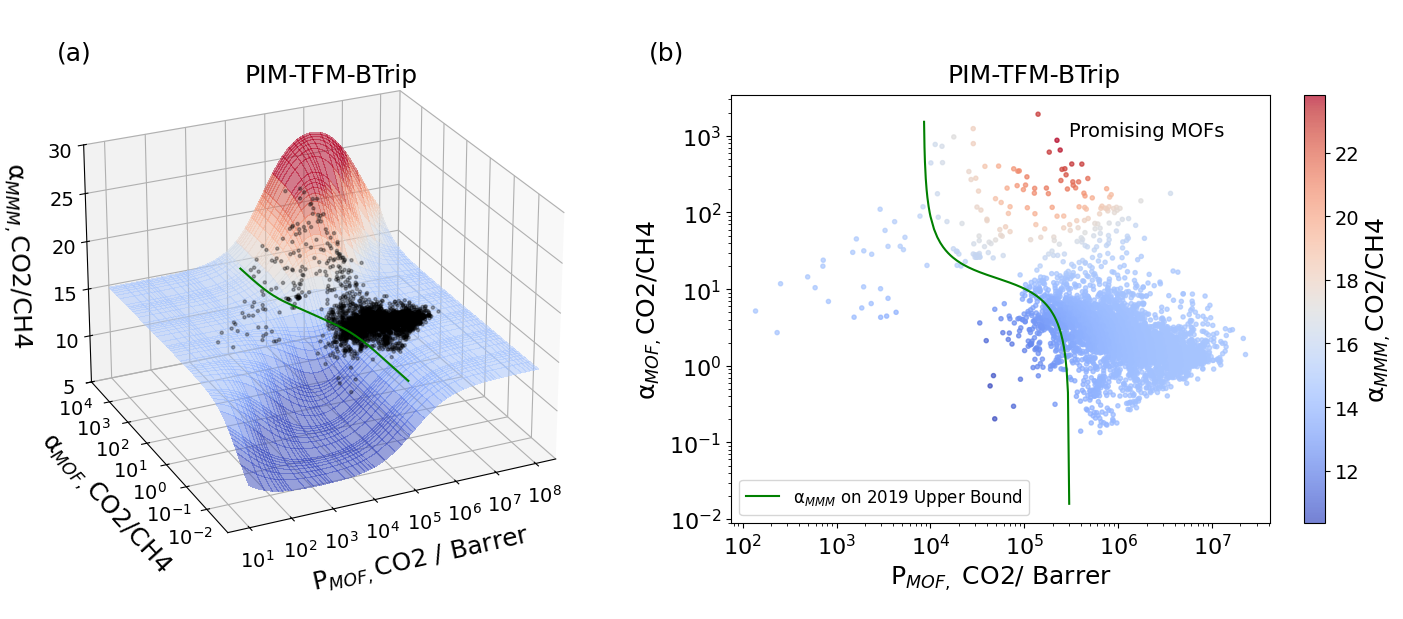

,MOF,CO2,CH4,MOF_α,MMM_P_mol_1/Barrer,MMM_P_mol_2/Barrer,MMM_α
0,ABAVIJ_clean,7.064235e+05,9.363672e+04,7.544300,48860.684751,3389.343487,14.415973
3,ABIYIV_clean,6.437629e+05,1.700475e+05,3.785782,48630.286560,3431.811563,14.170442
4,ABULOB_clean,9.282884e+05,3.726769e+05,2.490866,49447.453111,3461.392481,14.285422
5,ABUWOJ_clean,1.466673e+06,1.108505e+06,1.323109,50173.800435,3478.341680,14.424632
6,ACAJIY_clean,4.718098e+05,1.074931e+05,4.389210,47731.739303,3401.298085,14.033389
...,...,...,...,...,...,...,...
7639,ncomms11831_ncomms11831-s2_clean,2.984966e+05,6.385677e+04,4.674471,46011.227047,3347.548067,13.744755
7640,ncomms11831_ncomms11831-s3_clean,7.778343e+05,3.745308e+05,2.076823,49082.468629,3461.517599,14.179465
7641,ncomms7350-s2_clean,1.237110e+06,6.287080e+05,1.967702,49936.420629,3471.749675,14.383647
7642,om701262m-file004_clean,1.594695e+06,8.059167e+05,1.978734,50278.002961,3475.092004,14.468107


In [4]:
get_MMM_P('CO2','CH4',MOF_predictions,polymer_P_co2,polymer_P_ch4,polymer_alpha,k_2019, n_2019,plot_figure=True,save_figure=False,save_data=False,polymer_name='PIM-TFM-BTrip')

In [162]:
print("MOF_P_pair_"+str(Loading_pressure))

MOF_P_pair_500000.0


### Section 2
All possible MOFs with many polymers under 1bar

In [5]:
##read polymer exp data
polymer_co2_ch4_exp=pd.read_excel('data/robeson_co2_ch4_close_to_upperbound.xlsx')

## Production

,MOF,CO2,CH4,Polypyrrole 6FDA/PMDA (25/75)-TAB,Polyimide TADATO/DSDA (1/1)-DDBT,Poly(diphenyl acetylene) 3a,Polyimide 6FDA-TMPDA/DAT (3:1),Poly(diphenyl acetylene) 3e,Polyimide 6FDA-TMPDA,6FDA-based polyimide (8),PIM-7,PIM-1,PTMSP,PIM-DM-Btrip,PIM-TFM-Btrip,PIM-DTFM-Btrip,PIM-TMN-Trip,Rnk_avg,Rnk_std,Good_count
0,ABAVIJ_clean,7.064235e+05,9.363672e+04,"[4.787032910713624, 0.0341932673366323, 139.99...","[68.81817408646205, 1.1470475991208047, 59.995...","[168.20330184071273, 3.5194611523957597, 47.79...","[286.8246209527978, 8.463036391958678, 33.8914...","[443.30719538345306, 14.078607891195293, 31.48...","[849.0789473964338, 37.428318844510464, 22.685...","[1462.7572545746575, 61.017258895079976, 23.97...","[1679.1650095586044, 94.971247363253, 17.68077...","[3503.7691333799753, 190.86572441807405, 18.35...","[42337.7241597319, 9226.977088989894, 4.588471...","[32460.344691361788, 2356.091498121332, 13.777...","[48860.68475096456, 3385.0438767965825, 14.434...","[60988.11767150338, 6298.578496348175, 9.68283...","[74551.44223213092, 10214.722687112398, 7.2984...",2255.142857,837.708000,3
3,ABIYIV_clean,6.437629e+05,1.700475e+05,"[4.7870303885231795, 0.03419327181857575, 139....","[68.81765291853013, 1.1470526427489474, 59.995...","[168.20018922075624, 3.5195086336180994, 47.79...","[286.8155729349014, 8.463310928262976, 33.8892...","[443.28559059047177, 14.079367590280407, 31.48...","[848.9997757412154, 37.43368691295764, 22.6801...","[1462.522663434221, 61.03152209240702, 23.9633...","[1678.8560478745999, 95.00578902741915, 17.671...","[3502.4304246573047, 191.00509896507768, 18.33...","[42161.63725587056, 9521.005114948746, 4.42827...","[32354.02618794856, 2376.847036373598, 13.6121...","[48630.286560077104, 3427.406290075799, 14.188...","[60640.85906894289, 6440.467364050847, 9.41559...","[74051.53006611834, 10570.717626570899, 7.0053...",3005.428571,276.684120,3
4,ABULOB_clean,9.282884e+05,3.726769e+05,"[4.787039103935298, 0.034193274804838567, 139....","[68.81945387533365, 1.147056003304692, 59.9965...","[168.21094584145283, 3.5195402712202797, 47.79...","[286.8468432330219, 8.463493868755974, 33.8922...","[443.36026412023614, 14.079873862288675, 31.48...","[849.2734820344348, 37.43726535877843, 22.6852...","[1463.3339522189906, 61.04103314840278, 23.972...","[1679.924662033504, 95.02883261209733, 17.6780...","[3507.0653596108923, 191.09819702064897, 18.35...","[42784.09747584703, 9741.58770470314, 4.391901...","[32727.933623686848, 2391.111086306223, 13.687...","[49447.45311080919, 3456.9119630468776, 14.303...","[61880.00123494936, 6543.063835525922, 9.45734...","[75847.20557028828, 10841.07494460698, 6.99628...",2793.285714,188.071958,3
5,ABUWOJ_clean,1.466673e+06,1.108505e+06,"[4.787046342543489, 0.03419327646838408, 139.9...","[68.82094980274192, 1.1470578753732374, 59.997...","[168.2198818851133, 3.519557895958977, 47.7957...","[286.8728254186626, 8.463595785760237, 33.8949...","[443.4223236165911, 14.080155921834654, 31.492...","[849.5010861577648, 37.4392594032586, 22.69011...","[1464.009186274165, 61.04633409598901, 23.9819...","[1680.8143443409922, 95.04167945111972, 17.685...","[3510.934331795312, 191.1501403817586, 18.3674...","[43332.55674954012, 9874.381235173476, 4.38838...","[33052.99206255931, 2399.213782305374, 13.7765...","[50173.80043503971, 3473.817439687888, 14.4434...","[62999.20340313843, 6603.308442309455, 9.54055...","[77497.70575120776, 11005.21324384689, 7.04190...",2297.214286,355.656772,3
6,ACAJIY_clean,4.718098e+05,1.074931e+05,"[4.787020025435539, 0.034193268622365, 139.998...","[68.81551172160613, 1.147049045974573, 59.9935...","[168.18740262909802, 3.5194747730396925, 47.78...","[286.7784089543359, 8.463115144283142, 33.8856...","[443.1968668445172, 14.078825808339914, 31.479...","[848.6747971103933, 37.4298584535729, 22.67373...","[1461.560413924676, 61.02134915913172, 23.9516...","[1677.589061583283, 94.98115099092823, 17.6623...","[3496.9522053853134, 190.90566359191314, 18.31...","[

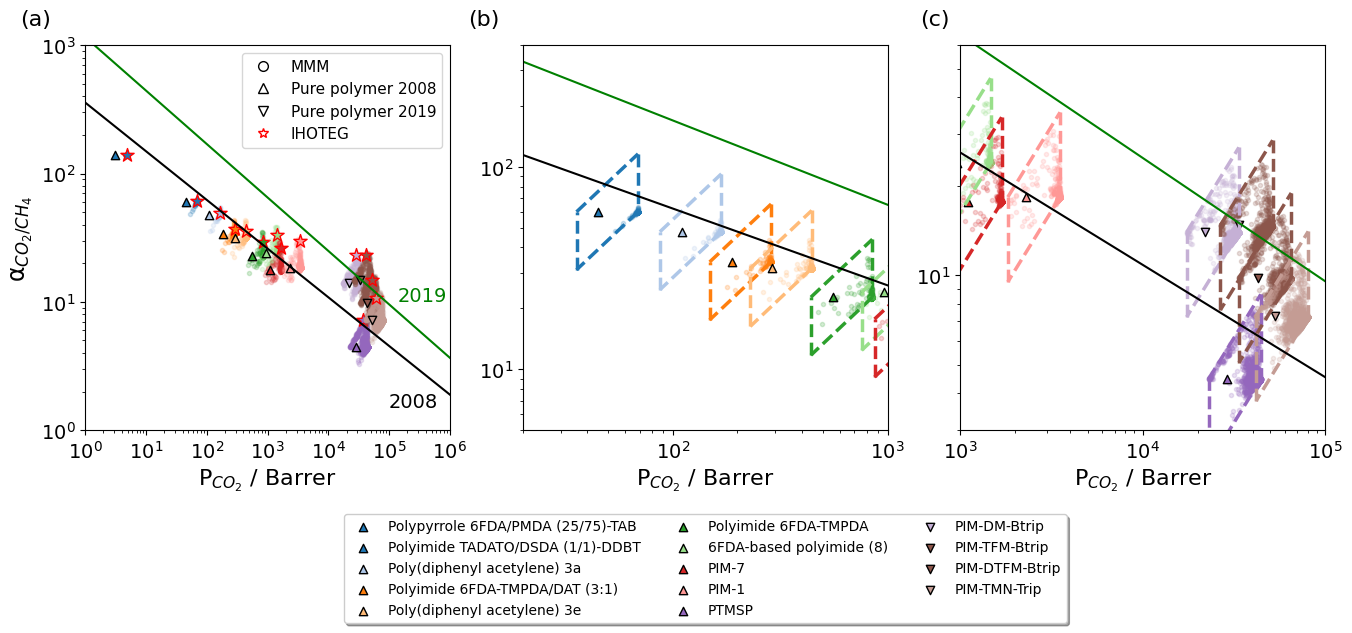

In [6]:
get_MMM_more_polymers('CO2','CH4',polymer_co2_ch4_exp.loc[[1,2,3,5,7,9,11,12,13,14,16,17,15,18],:].reset_index(drop=True)\
                      ,MOF_predictions,2008, 2019, k_2008, n_2008,\
                          k_2019, n_2019, 'IHOTEG',139809.624615,72.938523)

### Section 3
All possible MOFs with 1 polymer under arbitrary pressure

In [7]:
############## Do loading predictions ######################
given_pressure=[5e5,1e6] # in pascal, can be a list of pressures

#read KH predictions 
DataMatrix_2019_K=pd.read_csv('data/MOF_2019_notrelaxed_K_preds.csv')
DataMatrix_2019_K['logK']=np.log10(DataMatrix_2019_K['K_average'])

pressure_df=pd.DataFrame(index=range(len(given_pressure)),columns=['pressure'])
pressure_df['pressure']=given_pressure

# Add a common column to both dataframes with a constant value to enable merging
pressure_df['key'] = 1
DataMatrix_2019_K['key'] = 1

# Perform the merge using the 'key' column
merged_K_unrelaxed_2019_data= pd.merge(DataMatrix_2019_K, pressure_df, on='key').drop('key', axis=1)

#add langmuir descriptor
merged_K_unrelaxed_2019_data['Langmuir_ratio_1']=merged_K_unrelaxed_2019_data['K_average']*merged_K_unrelaxed_2019_data['pressure']/(1+merged_K_unrelaxed_2019_data['K_average']*merged_K_unrelaxed_2019_data['pressure'])

#choose the three molecules, and clean the columns
descriptor_list=['PLD', 'LCD', 'VF', 'percentile-0.01', 'percentile-0.1',
       'percentile-0.25', 'percentile-0.5', 'percentile-0.75',
       'percentile-1.0', 'percentile-2.5', 'percentile-5.0', 'percentile-7.5',
       'percentile-10', 'percentile-25', 'mu_0.25-0.01', 'mu_0.25-0.1',
       'mu_0.25-0.25', 'mu_0.25-0.5', 'mu_0.25-0.75', 'mu_0.25-1.0',
       'mu_0.25-2.5', 'mu_0.25-5.0', 'mu_0.25-7.5', 'mu_0.25-10', 'mu_0.25-25',
       'mu_0.5-0.01', 'mu_0.5-0.1', 'mu_0.5-0.25', 'mu_0.5-0.5', 'mu_0.5-0.75',
       'mu_0.5-1.0', 'mu_0.5-2.5', 'mu_0.5-5.0', 'mu_0.5-7.5', 'mu_0.5-10',
       'mu_0.5-25', 'Tc', 'Pc', 'w', 'xlogP', 'diameter_1', 'diameter_2',
       'diameter_3', 'logK', 'Langmuir_ratio_1', 'pressure']

L_unrelaxed_2019_data_cleaned=merged_K_unrelaxed_2019_data[['MOF', 'molecule', 'PLD', 'LCD',
       'VF', 'percentile-0.01', 'percentile-0.1', 'percentile-0.25',
       'percentile-0.5', 'percentile-0.75', 'percentile-1.0', 'percentile-2.5',
       'percentile-5.0', 'percentile-7.5', 'percentile-10', 'percentile-25',
       'mu_0.25-0.01', 'mu_0.25-0.1', 'mu_0.25-0.25', 'mu_0.25-0.5',
       'mu_0.25-0.75', 'mu_0.25-1.0', 'mu_0.25-2.5', 'mu_0.25-5.0',
       'mu_0.25-7.5', 'mu_0.25-10', 'mu_0.25-25', 'mu_0.5-0.01', 'mu_0.5-0.1',
       'mu_0.5-0.25', 'mu_0.5-0.5', 'mu_0.5-0.75', 'mu_0.5-1.0', 'mu_0.5-2.5',
       'mu_0.5-5.0', 'mu_0.5-7.5', 'mu_0.5-10', 'mu_0.5-25', 'Tc', 'Pc', 'w',
       'xlogP', 'diameter_1', 'diameter_2', 'diameter_3', 'logK','Langmuir_ratio_1', 'pressure']].copy()


def transfer_predicted_y(y_predict):
    y_predict_actual=[]
    for i in range(len(y_predict)):
        if y_predict[i]>=0:
            y_predict_actual.append(y_predict[i])
        else:
            y_predict_actual.append(10**y_predict[i])
    return y_predict_actual

for i in range(10):
    temp_regressor = pickle.load(open('ML_models/c_ML/c_reg_{}.pkl'.format(i),'rb'))
    L_unrelaxed_2019_data_cleaned['predict_L_{}'.format(i)]=transfer_predicted_y(temp_regressor.predict(L_unrelaxed_2019_data_cleaned[descriptor_list].values))


L_unrelaxed_2019_data_cleaned['L_average']=np.mean(L_unrelaxed_2019_data_cleaned.iloc[:,48:58],axis=1)
L_unrelaxed_2019_data_cleaned['L_std']=np.std(L_unrelaxed_2019_data_cleaned.iloc[:,48:58],axis=1)

[23:31:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[23:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differenc

In [8]:
##############read mof D ML predictions###################
df_Ds_all_final=pd.read_csv('data/MOF_2019_notrelaxed_D_preds.csv')
L_D=pd.merge(df_Ds_all_final,L_unrelaxed_2019_data_cleaned[['MOF','molecule','pressure','L_average']],on=['MOF','molecule'],how='left')
for problematic_mof in L_D[L_D['L_average'].isna()].MOF.unique():
    L_D=L_D.drop(index=L_D[L_D['MOF']==problematic_mof].index)

In [9]:
#get density of the MOFs
mof_density=pd.read_csv('data/2019_not_relaxed_density.txt',sep='\t',header=None)
mof_density.columns=['MOF','Density']
mof_density[['MOF','other']] = mof_density.iloc[:,0].str.split('_volpo',expand=True)
mof_density=mof_density.drop(columns=['other'])
mof_density[['MOF','other']] = mof_density.iloc[:,0].str.split('.txt',expand=True)
mof_density=mof_density.drop(columns=['other'])
mof_density['Density/kg/m3']=mof_density['Density']*1000

L_D_merged=pd.merge(L_D,mof_density[['MOF','Density/kg/m3']],how='left',on='MOF')
if not L_D_merged[L_D_merged.duplicated()].empty:
    L_D_cleaned=L_D_merged.drop(index=L_D_merged[L_D_merged.duplicated()].index).reset_index(drop=True).copy()
else:
    L_D_cleaned=L_D_merged.copy()


In [10]:
#do unit conversions
"""P Barrer


Solubility = L/P
L: mol/kg to mol/m3 P:Pa
Density: kg/m3
S: mol/m3/Pa

D: cm2/s to m2/s

P = D*S mol m2/ (m3 Pa s)
Barrer = 3.348 × 10-16 mol m/ (m2 s Pa)

"""

def get_P(temp_df, Loading_pressure):
    MOF_density = temp_df.iloc[0,-1] #kg/m3
    mol_D = temp_df.iloc[0,-4]#cm2/s
    #unit conversion of D
    mol_D = mol_D * 1e-4 #m2/s
    mol_L = temp_df.iloc[0,-2] #mol/kg
    mol_L = mol_L * MOF_density #mol/m3
    mol_Solubility = mol_L/Loading_pressure #mol/m3/Pa
    mol_P = mol_D*mol_Solubility #m2 mol/m3 Pa s
    return mol_P/3.348/1e-16 #barrer

for Loading_pressure in given_pressure[:1]:

    globals()["MOF_P_pair_"+str(Loading_pressure)]=pd.DataFrame(index=range(len(L_D_cleaned.MOF.unique())), columns=['MOF','O2','N2','CO2','CH4','H2','He'])
                             
    globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[:,0]=L_D_cleaned.MOF.unique()

    for i in range(globals()["MOF_P_pair_"+str(Loading_pressure)].shape[0]):
        mof = globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,0]
        temp_O2 = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='O2')]
        temp_N2 = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='N2')]
        temp_CO2 = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='CO2')]
        temp_CH4 = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='CH4')]
        temp_H2 = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='H2')]
        temp_He = L_D_cleaned[(L_D_cleaned['MOF']==mof) & (L_D_cleaned['molecule']=='He')]
    
        if not temp_O2.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,1] = get_P(temp_O2,Loading_pressure)
        if not temp_N2.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,2] = get_P(temp_N2,Loading_pressure)
        if not temp_CO2.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,3] = get_P(temp_CO2,Loading_pressure)
        if not temp_CH4.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,4] = get_P(temp_CH4,Loading_pressure)
        if not temp_H2.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,5] = get_P(temp_H2,Loading_pressure)
        if not temp_He.empty:
            globals()["MOF_P_pair_"+str(Loading_pressure)].iloc[i,6] = get_P(temp_He,Loading_pressure)
            
    

globals()["MOF_P_pair_"+str(Loading_pressure)] is the new MOF_predictions dataframe in previous sections. Use the same production functions above to produce the data. 